In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [10]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [11]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [12]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [13]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [14]:
# Save references to each table
Measurement = Base.classes.measurement
Stations = Base.classes.station

In [15]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [16]:
# Inspect table to see data names and types
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [17]:
# Find the most recent date in the data set.
latest_date = session.query(Measurement.date).\
                        order_by(Measurement.date.desc()).\
                        limit(1).all()[0][0]
print(latest_date)

2017-08-23


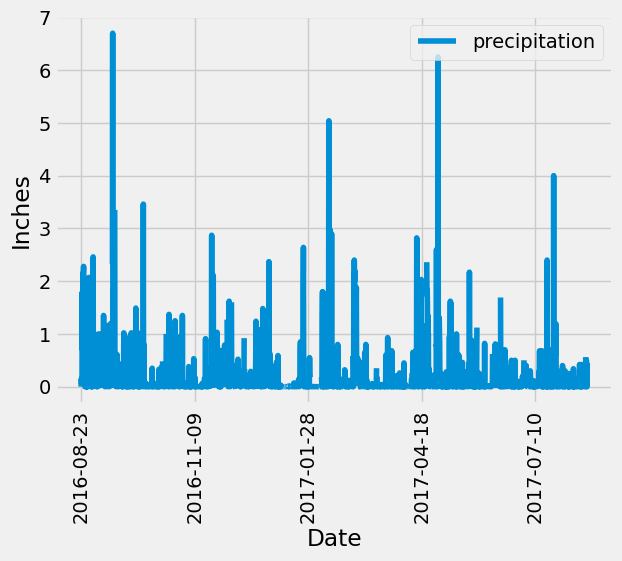

In [45]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
a_year_ago = dt.datetime.strptime(latest_date,'%Y-%m-%d') - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
Data = session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date > a_year_ago).\
        order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
Data_df = pd.DataFrame(Data,columns=["date","precipitation"])
Data_df.set_index('date',inplace=True)

# Sort the dataframe by date
Data_df1 = Data_df.sort_values(by = 'date')

# Use Pandas Plotting with Matplotlib to plot the data
graph=Data_df1.plot.line(rot=90, ylabel='Inches', xlabel='Date')
graph.legend(loc='upper right')
plt.show()

In [46]:
# Use Pandas to calculate the summary statistics for the precipitation data
Data_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [50]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(Stations.id).count()
station_count

9

In [53]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active = session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()
most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [77]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
top_most_active = most_active[0][0]
sel = [func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs),]

active_station = session.query(*sel).\
    group_by(Measurement.station).\
    filter(Measurement.station == top_most_active).all()

active_station

[(54.0, 85.0, 71.66378066378067)]

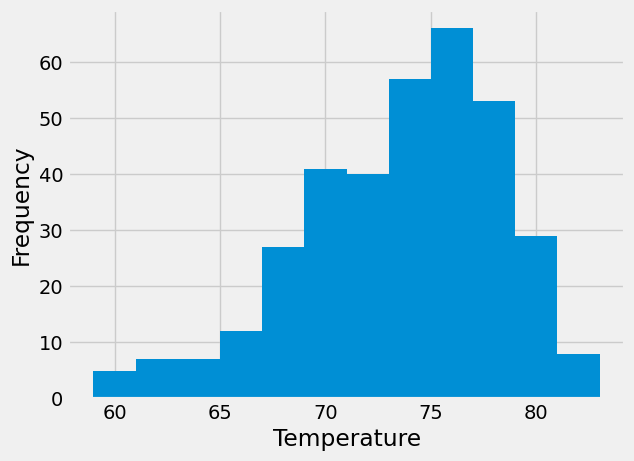

In [85]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Query
top_data = session.query(Measurement.station, Measurement.tobs).\
    filter(Measurement.date >= a_year_ago).\
    filter(Measurement.station==top_most_active)

# Make dataframe
top_data_df = pd.DataFrame(top_data, columns=['date', 'tobs'])

# Create Graph 
hist = top_data_df['tobs'].hist(bins=12)

plt.xlabel('Temperature')
plt.ylabel('Frequency')

plt.show()


# Close Session

In [16]:
# Close Session
session.close()